# Statistics for Engineers

Tuorial at SRECon 2015

by Heinrich Hartmann

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (14,4)

np.random.seed(9221999)

import math
import seaborn as sns
import random

<img src="img/me.jpg" width="200px" style="float:right">

## Heinrich Hartmann

* Twitter: [@HeinrichHartman](https://twitter.com/HeinrichHartman)
* Blog: [HeinrichHartmann.com](https://heinrichhartmann.com)

<h3 style="clear:both">Bio</h3>

* PhD in pure Mathematics (Mainz, Bonn)

* Postdoc (Oxford, Koblenz) in IT

* Freelance Consultant

* Now: Data Scientist at Circonus.com


<img src="img/Circonus_Logo.png" style="margin-right:auto; margin-left:auto">



## SRE Challenges

* Check SLA
  - Quantiles
  - Mean values

* Capacity Planning
  - Regressions
  - Forecasting
  - Scatter plots

* Evaluate Changes
  - Compare response time before and after code change
  

# Quotes from Feedback form

What Challenges did you face recently?

- "I needed to decide on a reasonable upper limit bandwidth cap for a web service for a future period, based on previous usage."
- "Estimating lost traffic for services outages."
- "I had to analyze [tons of data] and had problems using libreoffice calc to handle the graphs."
- "I now work in an environment that is 1/3 statisticians."


# Goals for this Tutorial

* Know how to read and produce a variety of data visualizations.  


* Mathematical background for basic descriptive statistical methods:
  - Mean values
  - Deviation measures
  - Quantiles
  - Correlation
  - Regression
  - R^2 values
  - Holt Winters Forecasting


* Hands on knowledge:
  - Handle data at the command line
  - Import data into IPython toolchain
  - Calculate statistical measures and produce plots

# Slides, Code and Data

* GitHub: https://github.com/HeinrichHartmann/StatisticsTutorial

* Also on Twitter: @HeinrichHartman

# Tutorial Outline

## 1. Descriptive Statistics

## 2. Data Handling Tools

## 3. Hands on Session

# Part I: Descriptive Statistics

* Not: Probability Theory
* Not: Parameter estimation
* Not: Bayesian inference
* Not: P-values, t-test


# Understanding and Summarizing Data

Given a list of numbers $X=[x_1, \dots, x_n]$ how can we understand the data?

* How many points are there?
* What are typical values?
* How large is the spread of the data?
* Is the data evenly distributed or clustered?
* Are there outliers?
* Are there trends?

Examples:

* CPU utilization
* API latencies
* Request rates
* Timestamps of events

# Unordered data

* Most data in IT comes sorted (linear memory!)
* Most questions do not depend on ordering
* Focus un-ordered data first, time dependent (ordered) data is covered later

Visualization Method:
1. Rug Plot
2. Histograms
3. Kernel density estimation

## Rug Plots

* Plot a vertical line 'rug' for each sample $x_i$ on a line.
* Simple and accurate representation of data

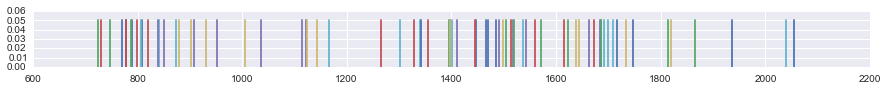

In [3]:
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
plt.figure(figsize=(15,1))

sns.rugplot(X);

## From Line Plots to Rug Plots

* Line plots are familiar from school
* Suggests continuity of data points
* Imposes a (linear) interpolation scheme
* Stresses time ordering of data (often irrelevant)

### Conversion steps:

1. Project point to y-axis
2. Rotate


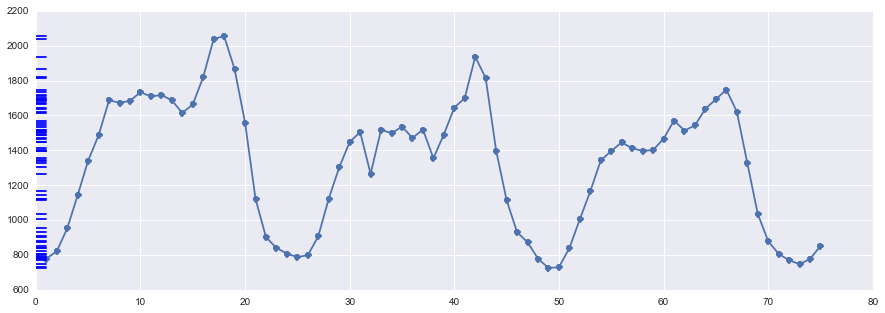

In [4]:
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
plt.figure(figsize=(15,5))
plt.plot(X,'o-') # use style 'o-' to show datapoints.
sns.rugplot(X,axis='y', height=1, color="blue");
plt.show()

### Rug plot for discrete values is problematic

* Multiple values not visible.

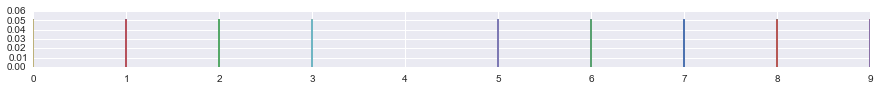

In [5]:
data_discrete = [1, 2, 1, 6, 0, 8, 0, 6, 5, 5, 9, 5, 7, 2, 9, 5, 0, 8, 8, 8, 8, 9, 3, 3 ] * 3
X = data_discrete

plt.figure(figsize=(15,1))
sns.rugplot(X);

### Jitter Trick

* Perturb each value by a random displacement.
* The displacement needs to be small in comparison to the distance between values.
* Can also use vertical displacement.

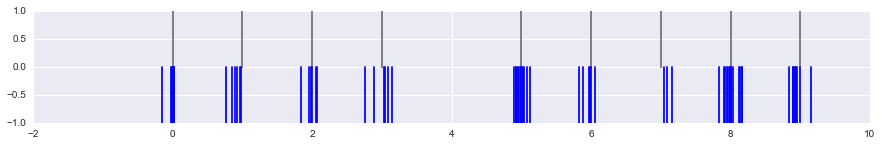

In [6]:
jitter = lambda x: [ v + 0.1 * np.random.normal() for v in x]

plt.figure(figsize=(15,2))
sns.rugplot(X, height=1, color='grey');
sns.rugplot(jitter(X), height=-1, color='blue');

## Histogram Visualization of Unordered Data

1. Divide data domain into bins.
2. Count number of datapoints per bin.
3. Plot bar chart of bin frequencies.

Advantags:
- Easy to visually comprehend
- Compare _area_ instead of number of rugs

The choice of bins is crucial:

* What is the outer boundaries (`bin_min`, `bin_max`)?
* How many bins should we take?
* Should the bins have equal size? (> Need normalization if not!)

# Histogram Computation

In [7]:
# Step0: Take some data (same as above)
X = data_discrete
print X[:5], "..."

[1, 2, 1, 6, 0] ...


In [8]:
# Step1: Choose bins
# - bis are represented by pairs [a,b]
# - a is inclusive
# - b is exclusive
bins = [ [i,i+1] for i in range(11) ]
print "Bins:  ", bins[:3], "...", bins[-1]

Bins:   [[0, 1], [1, 2], [2, 3]] ... [10, 11]


In [9]:
# Step2: Count number of samples in bins
def count(X, bins):
    def findBin(x, bins):
        for i, bin in enumerate(bins):
            left, right = bin
            if left <= x and x < right:
                return i
        return None
    
    count = [0] * len(bins)
    for x in X:
        i = findBin(x, bins)
        if i != None:
            count[i] += 1

    return count

print "Counts:", count(X, bins)

Counts: [9, 6, 6, 6, 0, 12, 6, 3, 15, 9, 0]


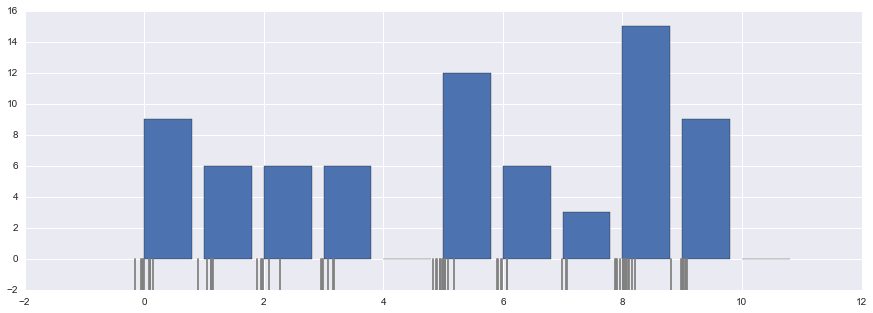

In [10]:
# Step3: Plot bar chart
def hist(X, bins, **kwargs):
    bin_left = [ left for left, right in bins ]
    plt.bar(bin_left, count(X, bins), **kwargs)

plt.figure(figsize=(15,5))
hist(X,bins)

# Add rugplot for comparison
sns.rugplot(jitter(X), height=-2, color='grey')
plt.show()

## Histogram of Request Rates

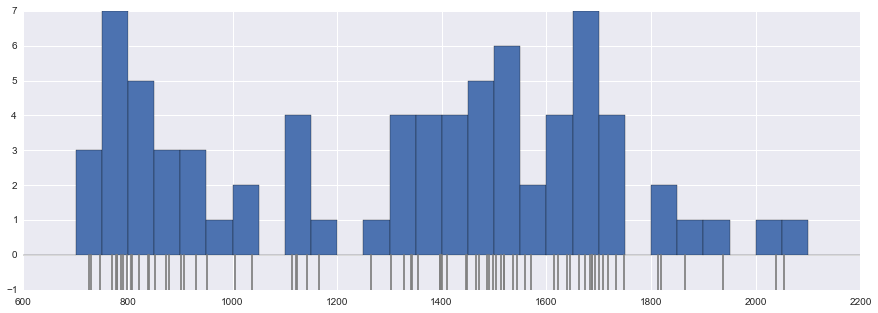

In [11]:
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]

# Sensible choices after manual inspection
bin_min = 600
bin_max = 2200
bin_width = 50

# Create bin list
bins = [ [i, i+bin_width] for i in range(bin_min, bin_max, bin_width) ]

plt.figure(figsize=(15,5))
hist(X,bins, width = bin_width)
sns.rugplot(X, color='grey', height=-1)
plt.show()

## Histograms with different bin width

* Small bin width: like rug-plot
   
* Large bin width: single column with count

* Different choices change look of histogram significantly

* Bin-offset can change appearance as well

Histogram with bin_width  10


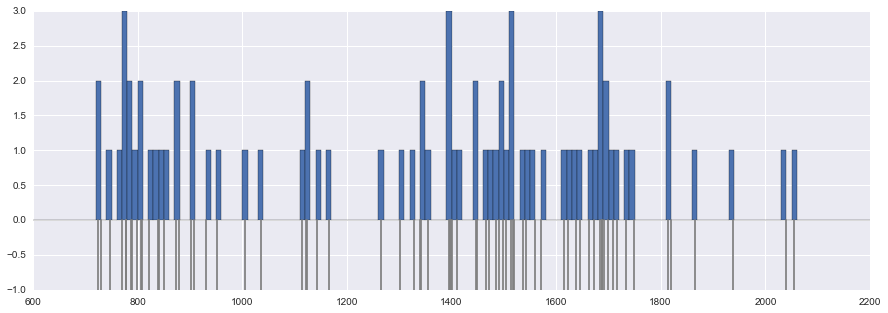

Histogram with bin_width  50


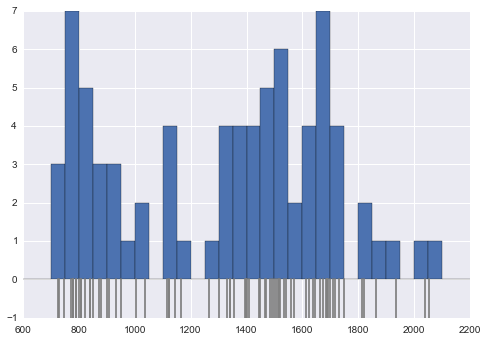

Histogram with bin_width  100


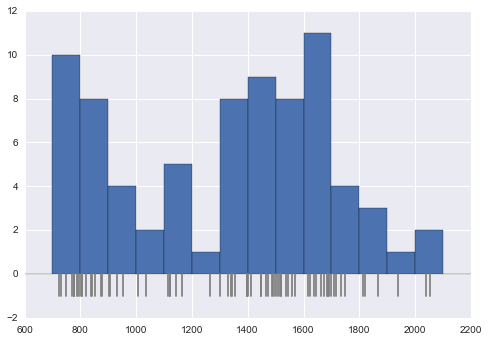

Histogram with bin_width  500


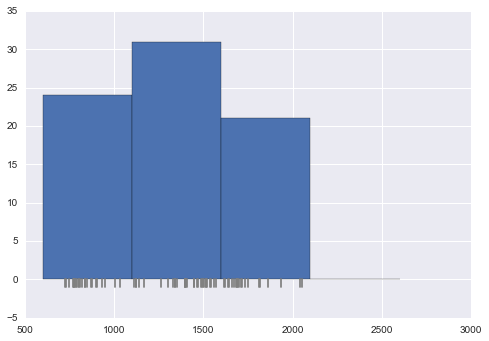

Histogram with bin_width  2000


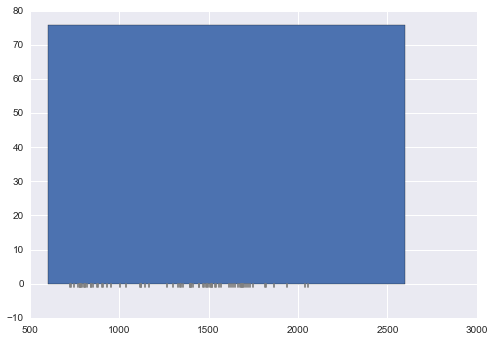

In [12]:
bin_min = 600
bin_max = 2200

def plot_hist(X,  bin_min, bin_max, bin_width):
    bins =[ [i, i+bin_width] for i in np.arange(bin_min, bin_max, bin_width) ]
    hist(X,bins,width=bin_width)
    sns.rugplot(X, color='grey', height=-1)
    print "Histogram with bin_width ", bin_width
    plt.show()

plt.figure(figsize=(15,5))
plot_hist(X, bin_min, bin_max, 10)
plot_hist(X, bin_min, bin_max, 50)
plot_hist(X, bin_min, bin_max, 100)
plot_hist(X, bin_min, bin_max, 500)
plot_hist(X, bin_min, bin_max, 2000)

## Common bin-width choices

Remarks:
* Can convert `bin_count` and `bin_width` using relation $$ bin\_max - bin\_min = bin\_count \cdot bin\_width.$$

* Choices `bin_min=min(X)` and `bin_max=max(X)` are common.

Choices for bin-width:

* Excel: Let $n$ be the number of samples, then:

  $$ bin\_count = \sqrt{n} $$

* Scott's normal reference rule

  $$ bin\_width = \frac{3.5 \sigma}{n^{1/3}} $$

  where $\sigma$ is the standard deviation (cf. later).
  This is optimal for random samples of normally distributed data, in a certain sense.

* Freedman–Diaconis rule

  $$ bin\_width = \frac{2 IQR}{n^{1/3}} $$
  
  where IQR is the inter-quartile range (cf. later). Like Scott's rule but more robust agains outliers.

Excel rule
Histogram with bin_width  152.493649279


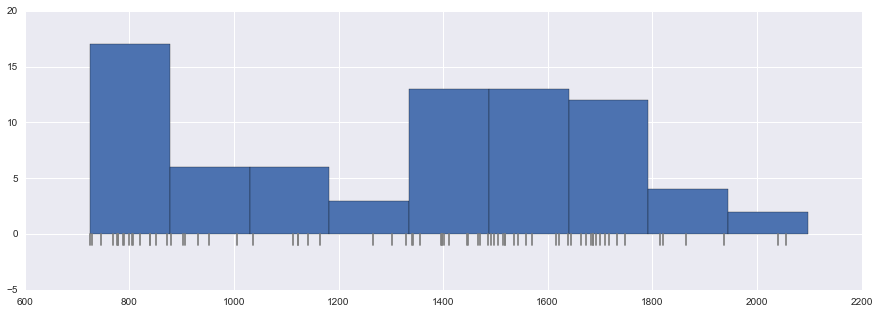

Scott's rule
Histogram with bin_width  309.50374768


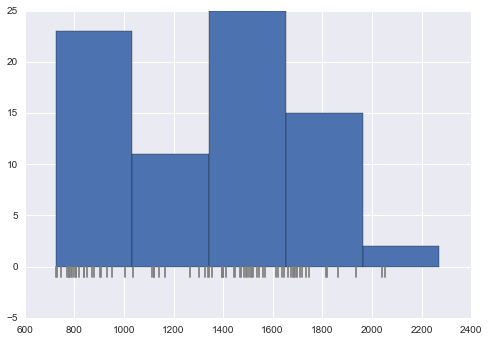

Freedman–Diaconis' rule
Histogram with bin_width  340.149900784


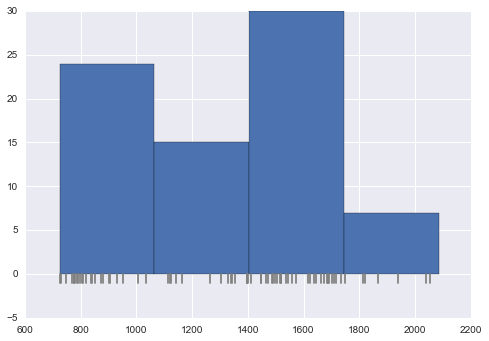

In [13]:
bin_min = min(X)
bin_max = max(X)

plt.figure(figsize=(15,5))

print "Excel rule"
plot_hist(X, bin_min, bin_max, (bin_max - bin_min)/math.pow(len(X),0.5))

print "Scott's rule"
plot_hist(X, bin_min, bin_max, 3.5 * np.std(X) / math.pow(len(X), 1./3))

print "Freedman–Diaconis' rule"
IQR = np.subtract(*np.percentile(X, [75, 25]))
plot_hist(X, bin_min, bin_max, 2 * IQR / math.pow(len(X), 1./3))

# Pragmatic Choice: Log sized bins

* Round values to n-significant digits to bin index

* Normailze count by bin size

* Good for float values (same scaling properties)


In [14]:
def find_log_bin(x):
    n = 2
    return round(x, -int(math.floor(math.log10(x))) + (n - 1))

print find_log_bin(0.123455)
print find_log_bin(12345)

0.12
12000.0


# Real-Life Example: Histograms as Heatmaps with Log-Bins

* Can use color coding for bin count
* Allows to show many histograms at once
* Harder to read off values
* Log scale bins

<center><img src="img/Circonus_Histogram.png"/></center>

2596


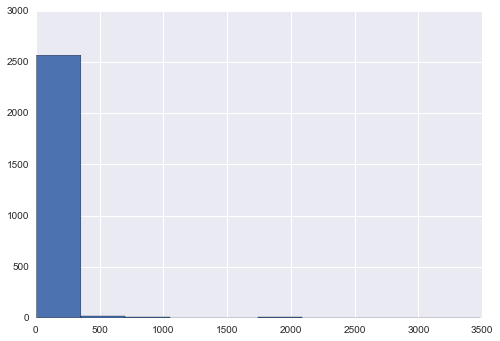

In [15]:
# Library Function: np.hist()
X = np.genfromtxt("DataSets/API_latencies.csv", delimiter=",")[:,1]
X=X[~np.isnan(X)]
print len(X)

plt.hist(X)
plt.show()

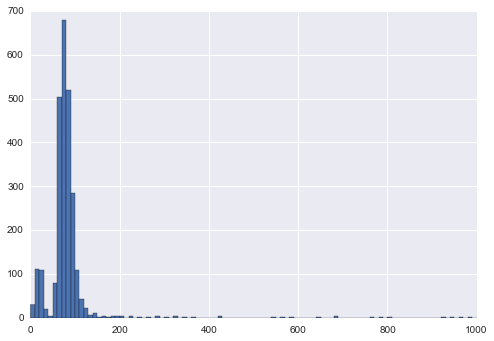

In [16]:
# Add more bins, limit range
plt.hist(X, bins=100, range=(0,1000))
plt.show()

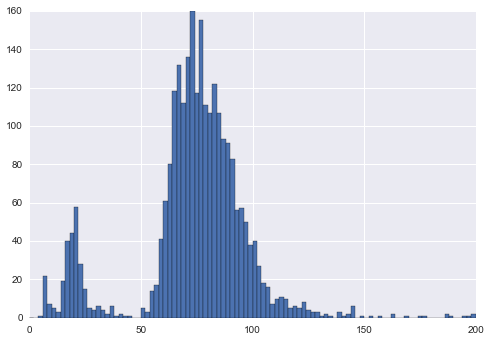

In [17]:
# Still smaller range
plt.hist(X, bins=100, range=(0,200))
plt.show()

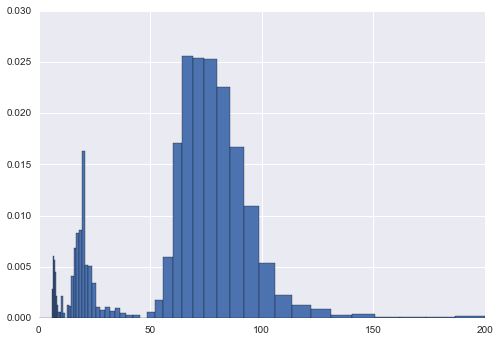

In [18]:
# Logarithmic bin sizes
bin_log_left = [ np.exp(x) for x in np.linspace(-1,np.log(200),90) ]
plt.hist(X,bins=bin_log_left,normed=True, range=(0,200))
plt.show()

## Digression: Kernel Density Estimators

1. Replace 'rugs" with little functions (e.g. triangles, rectangles, normal-distributions)
2. Sum all functions

<center>
<img src="http://upload.wikimedia.org/wikipedia/en/4/41/Comparison_of_1D_histogram_and_KDE.png" width='400px'>

Source: Wikipdeia, CC BY-SA 3.0, by Drleft <br>
http://en.wikipedia.org/wiki/Kernel_density_estimation
</center>

Remarks:

* Smooth version of Histogram
* Better approximation for pdf (cf. later)
* More expensive to compute
* Harder to define
* Choices of function and width invloved. Similar to Histogram.


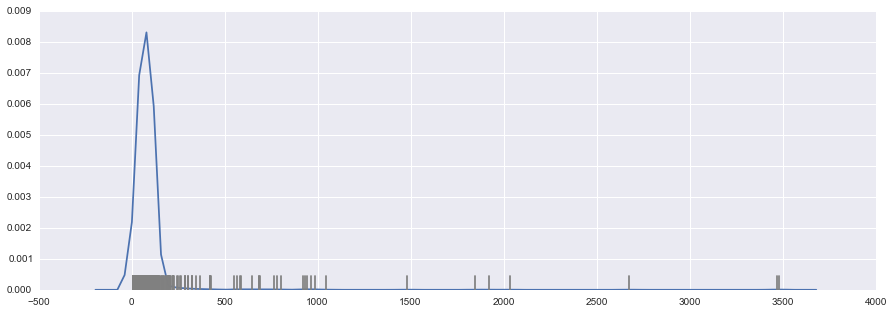

In [19]:
from sklearn.neighbors import KernelDensity

KDE=KernelDensity(kernel='epanechnikov', bandwidth=80)
KDE.fit(X[:,np.newaxis])
grid=np.linspace(min(X)-200, max(X)+200,100)
kde =np.exp(KDE.score_samples(grid[:,np.newaxis]))

plt.figure(figsize=(15,5))
plt.plot(grid, kde)
sns.rugplot(X, color='grey')

# Summarizing unordered data

* Have talked about visualizations
* Now: Summary statistics

## Mean Values

The _mean value_ of $x_1, \dots, x_n$ is defined as

$$ \mu = mean(x_1, \dots, x_n) = \frac{1}{n} \sum_{i=1}^n x_i. $$

- Represnets center of mass
- If the values are close together this is a good representative
 

mean= 1316.30863471


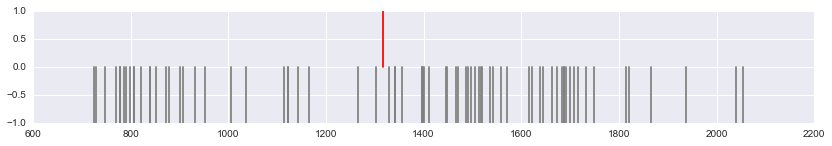

In [20]:
def mean(X):
    return float(sum(X)) / len(X)

X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
print "mean=", mean(X)

# Plot
def mark(m,height=1,style='r'):
    plt.plot([m,m],[0,height],style)

def plot_mean(X):
    sns.rugplot(X, color='grey', height=-1)
    mark(mean(X))
    plt.show()

plt.figure(figsize=(14,2))
plot_mean(X)

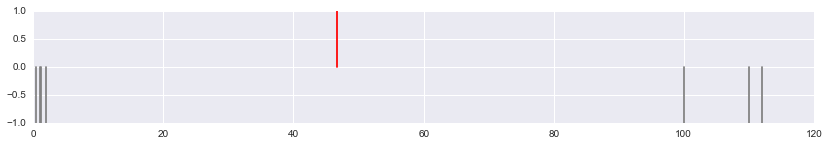

In [21]:
# Mean values can be atypical

plt.figure(figsize=(14,2))
plot_mean([1,2,0.4,1.2,100,110,112])

## Median

A _median value_ for $x_1, \dots, x_n$ is number $m$ such that
  
 $$ \# \{ i \,|\, x_i \leq m \} = \# \{ i \,|\, x_i \geq m \}. $$

So the number of samples smaller than $m$ is equal to the number of samples larger than $m$.
(Both should be roughly $n/2$).

A median can be computed as follows:

1. Let $S = sort(x_1, \dots, x_n)$, so that $s_1 \leq s_2 \leq \dots \leq s_n$.

2. If $n$ is odd then $m = s_{(n+1)/2}$ is the unique median.

3. If $n$ is even, and $a = floor(\frac{n+1}{2})$ and $b = ceil(\frac{n+1}{2})$ are the middle indices, then every number $m$ with 
  $$s_a \leq m \leq s_b$$
  is a median.
  
Remark:

* Median is not unique
* Not influenced by outliers (robust)

In [24]:
# Median Implementation

# Caution: Index start at 0 in python!
def median_min(X):
    S = sorted(X)
    n = len(X)
    return S[int(math.floor((n+1)/2.))-1]

def median_max(X):
    S = sorted(X)
    n = len(X)
    return S[int(math.ceil((n+1)/2.))-1]

def plot_median_range(X):
    mark(median_max(X),1,'b')
    mark(median_min(X),1,'b')
    plt.plot([median_min(X),median_max(X)],[0.5,0.5],'b--')


def plot_mean_median(X):
    plt.figure(figsize=(14,2))
    sns.rugplot(X, color='grey', height=-1)
    mark(mean(X),1, 'r-')
    plot_median_range(X)
    plt.show()

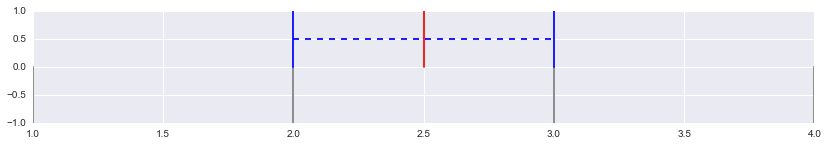

In [25]:
# even case
plot_mean_median([1,2,3,4])

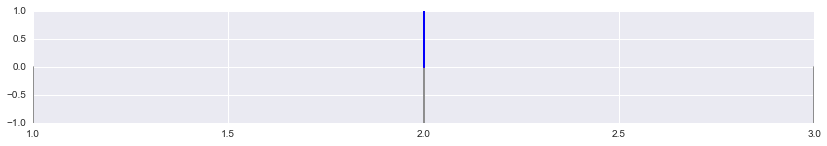

In [26]:
# odd case
plot_mean_median([1,2,3])

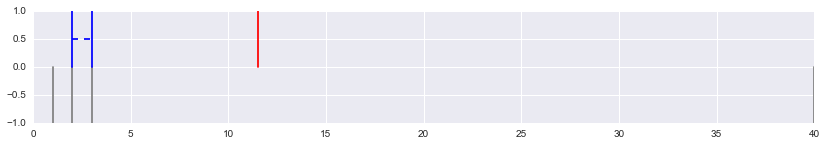

In [27]:
# With an outlier
plot_mean_median([1,2,3,40])

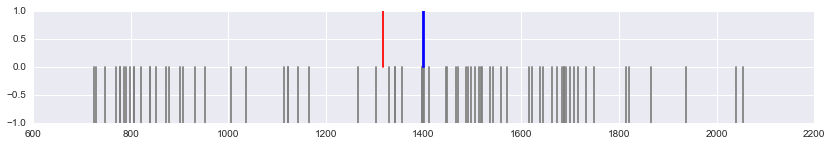

In [28]:
# Request data
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
plot_mean_median(X)

# Deviation Measures

1. The _maximal deviation_ is defined as

$$ maxdev(x_1,\dots,x_n) = max \{ |x_i - \mu| \,|\, i=1,\dots,n\}.$$

2. The _mean absolute deviation_ is defined as

$$ mad(x_1,\dots,x_n) = \frac{1}{n} \sum_{i=1}^n |x_i - \mu|.$$

3. The _standard deviation_ is defined as

$$ \sigma = stddev(x_1,\dots,x_n) =  \sqrt{\frac{1}{n} \sum_{i=1}^n (x_i - \mu)^2}.$$


* Measure the 'typical' displacement from the mean value.
* Standard deviation is popular because it has extremely nice mathematical properties.

In [29]:
def max_dev(X):
    m = mean(X)
    return max(abs(x - m) for x in X)

def mad(X):
    m = mean(X)
    return sum(abs(x - m) for x in X) / float(len(X))

def stddev(X):
    m = mean(X)
    return math.pow(sum((x - m)**2 for x in X) / len(X), 0.5)

# Plotting helper function
def plot_mean_dev(X, m, s):
    print "mean = ", m
    print "dev  = ", s
    plt.figure(figsize=(14,1))
    sns.rugplot(X, color='grey')
    plt.plot([m,m],[0,-0.09],'r-' )
    plt.plot([m-s,m-s],[0,-0.08],'b-')
    plt.plot([m+s,m+s],[0,-0.08],'b-')
    plt.plot([m-s,m+s],[-0.04,-0.04],'b--')
    plt.show()

Maximal deviation
mean =  1316.30863471
dev  =  738.072957089


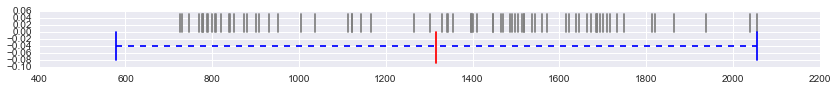

Standard Deviation
mean =  1316.30863471
dev  =  374.572363954


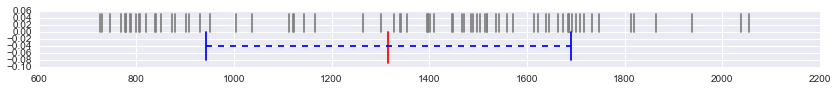

Mean Absolute Deviation
mean =  1316.30863471
dev  =  327.4656915


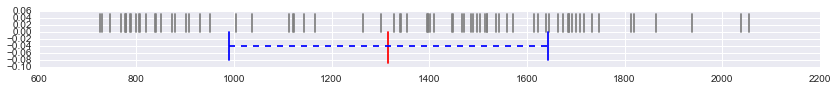

In [30]:
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
    
print "Maximal deviation"
plot_mean_dev(X,mean(X),max_dev(X))

print "Standard Deviation"
plot_mean_dev(X,mean(X),stddev(X))

print "Mean Absolute Deviation"
plot_mean_dev(X,mean(X),mad(X))

mean =  -0.0899801300331
dev  =  0.98277215849


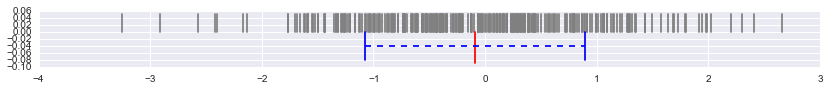

In [31]:
# Standard deviation is a good deviation for normal distributed data
X = [ np.random.normal() for x in range(300) ]
plot_mean_dev(X,mean(X),stddev(X))

mean =  0.574770634518
dev  =  11.5555487119


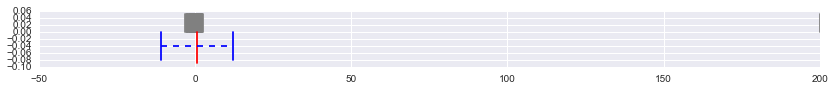

In [32]:
# Large effect on Outliers
X = X + [200]
plot_mean_dev(X,mean(X),stddev(X))

mean =  155.97706744
dev  =  428.835150092


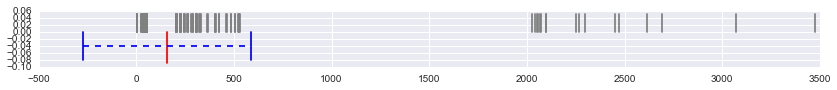

In [33]:
# No good description for 'skew' data
X = np.genfromtxt("DataSets/API_latencies.csv", delimiter=",")[:500,3]
plot_mean_dev(X,mean(X), stddev(X))

## Caution with Standard Deviation

- Everybody Learns about standard deviation in school
- Beautiful mathematical properties!
- Everybody knows 
  - "68% of data falls within 1 std-dev of the mean"
  - "95% falls within 2 std-dev of the mean"
  - "99.7" falls within 3 std-dev of the mean"
* "Problem is: this is utter nonsense". Only true for normally distributed data.

* Not good for measuring outliers!


Source: Janert - Data Analysis with Open Source Tools

## War Story:

- Looking at SLA for DB response times
- Outlier defined as value larger than $\mu + 3\sigma$
- Look at code: Takes '0.3' percentile!
- So always have outliers.
- And 0.3-percentile was way too large (hours of latency).
- Programmer changed code for 1%, 5%, 10% quantiles.
- Finally handcoded a threshold
- The SLA was never changed

Source: Janert - Data Analysis with Open Source Tools

### Digression: p-deviations

$$ \sigma_p=dev_p(x_1,\dots,x_n) =  (\frac{1}{n} \sum_{i=1}^n |x_i - \mu|^p)^{1/p}, \quad 1 \leq p \leq \infty $$

* $\sigma_1(X) = mead(X)$ is the mean absolute deviation
* $\sigma_2(X) = \sigma(X)$ is the standard deviation.
* $\sigma_\infty(X)$ is the max-deviation!

In [34]:
# Numerical check of the last claim
import math
def pdev(X, p=2):
    m = mean(X)
    return math.pow(sum( math.pow(abs(x - m),p) for x in X)/ len(X), 1./p) 

X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
print "     mean_abs_dev =", mad(X)
for p in [1,2,3,5,10,100]:
    print "p = %3d      pdev = %.3f" % (p , pdev(X,p))
print "          max-dev =", max_dev(X)

     mean_abs_dev = 327.4656915
p =   1      pdev = 327.466
p =   2      pdev = 374.572
p =   3      pdev = 407.987
p =   5      pdev = 455.236
p =  10      pdev = 530.342
p = 100      pdev = 707.648
          max-dev = 738.072957089


# Quantiles

Let $0\leq q \leq 1$ be a real number. A $q$-quantile for $X$ is a value $y$ such that, if

$$ \#\{i \,|\, x_i \leq y \} \geq q \cdot n  $$

and

$$ \#\{i \,|\, x_i \geq y \} \geq (1-q) \cdot n $$

Roughly speaking, $y$ divides $X$ in $q \cdot n$ samples that are lower than $y$ and $(1-q) \cdot n$ samples that are larger than $y$.

Examples:

* The minimum is a 0-quantile
* A median is a 0.5-quantile
* The maximum is a 1-quantile

Special names:

* Quartiles: $k/4$-quantiles
* Percentiles: $k/100$-quantiles

# Computation of Quantiles

Let `S = sorted(X)` be the sorted version of $X$, then both

* $s_a$ for $a = floor(q \cdot (n + 1))$, and
* $s_b$ for $b = ceil(q \cdot (n + 1))$ 

are q-quantiles for X if they lie in $1 .. n$.

* Quantiles always exists
* Non unique (like median)
* Lot's of ways to choose a quantile function, i.e. interpolate between s_a and s_b cf.  
  http://en.wikipedia.org/wiki/Quantile#Estimating_the_quantiles_of_a_population

In [35]:
def min_quantile(q,X):
    S = sorted(X)
    n = len(X)
    d = int(math.floor(q * (n + 1)))
    if d == 0:   return S[0]
    if d == n+1: return S[-1]
    return S[d-1]
    
def max_quantile(q,X):
    S = sorted(X)
    n = len(X)
    d = int(math.ceil(q * (n + 1)))
    if d == 0:   return S[0]
    if d == n+1: return S[-1]
    return S[d-1]

def quantile(q,X):
    # Warning: bad performance
    return (max_quantile(q,X) + min_quantile(q,X)) / 2.

In [36]:
def plot_quantiles(X,Q):
    # Warning: bad performance
    plt.figure(figsize=(14,1))
    sns.rugplot(X, color='grey', height=1)
    for q in Q:
        yr = min_quantile(q,X)
        yl = max_quantile(q,X)
        y = (yr + yl) / 2.
        print "{}-Qunatile \t= [{:.1f} <- {:.2f} -> {:.1f}]".format(q,yr,y,yl)
        plt.plot([y,y],[0,-1],'b-')
    plt.show()

0-Qunatile 	= [-1.0 <- -1.00 -> -1.0]
0.1-Qunatile 	= [-1.0 <- -1.00 -> -1.0]
0.5-Qunatile 	= [-1.0 <- 0.00 -> 1.0]
0.9-Qunatile 	= [1.0 <- 1.00 -> 1.0]
1-Qunatile 	= [1.0 <- 1.00 -> 1.0]


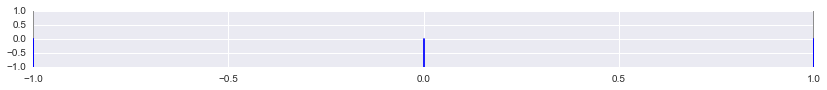

In [37]:
# Example -1, 1
plot_quantiles([-1,1],[0,0.1,0.5,0.9,1])

0-Qunatile 	= [1.0 <- 1.00 -> 1.0]
0.1-Qunatile 	= [1.0 <- 1.00 -> 1.0]
0.5-Qunatile 	= [2.0 <- 2.50 -> 3.0]
0.9-Qunatile 	= [4.0 <- 4.00 -> 4.0]
1-Qunatile 	= [4.0 <- 4.00 -> 4.0]


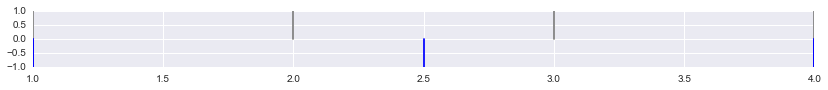

In [38]:
# Example 2
plot_quantiles([1,2,3,4],[0,0.1,0.5,0.9,1])

0-Qunatile 	= [725.0 <- 724.97 -> 725.0]
0.1-Qunatile 	= [778.6 <- 782.86 -> 787.2]
0.5-Qunatile 	= [1398.1 <- 1399.66 -> 1401.2]
0.9-Qunatile 	= [1733.2 <- 1740.55 -> 1747.9]
1-Qunatile 	= [2054.4 <- 2054.38 -> 2054.4]


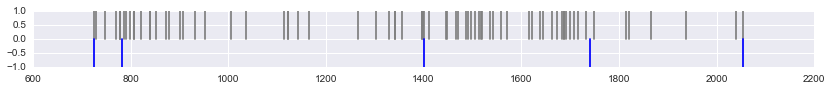

In [39]:
# Example Request Rate Data
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
plot_quantiles(X,[0,0.1,0.5,0.9,1])

# Example: Ping Latency Quantiles

* Plot of (Twitter) ping latencies
* With Quantiles as horizontal lines
  - Q(1) = max
  - Q(0.99)
  - Q(0.95)


<img src="img/Circonus_Quantiles.png">

Demo: https://parlette.circonus.com/trending/graphs/view/65d896dd-2be3-4be9-a76d-6fec209358b1#set-eUQdkrEI


Manual Quantiles
0-Qunatile 	= [725.0 <- 724.97 -> 725.0]
0.1-Qunatile 	= [778.6 <- 782.86 -> 787.2]
0.5-Qunatile 	= [1398.1 <- 1399.66 -> 1401.2]
0.9-Qunatile 	= [1733.2 <- 1740.55 -> 1747.9]
1-Qunatile 	= [2054.4 <- 2054.38 -> 2054.4]


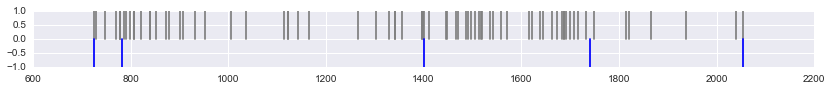

Library Quantiles
724.97
788.45
1399.66
1725.10
2054.38


In [40]:
# Library Function: np.percentile
#
# np.percentile?
#
# http://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html
#

print "Manual Quantiles"

X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
plot_quantiles(X,[0,0.1,0.5,0.9,1])

print "Library Quantiles"

for y in np.percentile(X,[0,10,50,90,100]):
    print "{:.2f}".format(y)


## Boxplot

* Median
* Box around 0.25 and 0.75 Quantiles
* "whiskers" from min to max

Usually shown in vertical direction.

Allows visual clues:

* Where is the data concentracted?
* How far is it spread?
* How skew is the data?

0-Qunatile 	= [725.0 <- 724.97 -> 725.0]
0.25-Qunatile 	= [901.7 <- 904.50 -> 907.3]
0.5-Qunatile 	= [1398.1 <- 1399.66 -> 1401.2]
0.75-Qunatile 	= [1622.3 <- 1630.39 -> 1638.5]
1-Qunatile 	= [2054.4 <- 2054.38 -> 2054.4]


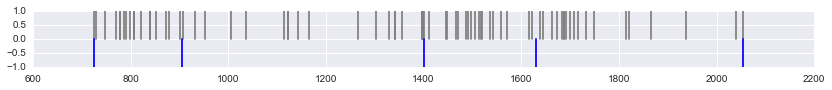

In [41]:
X = np.loadtxt("DataSets/RequestRates.csv", delimiter=",")[:,1]
plot_quantiles(X,[0,0.25,0.5,0.75,1])
plt.show()

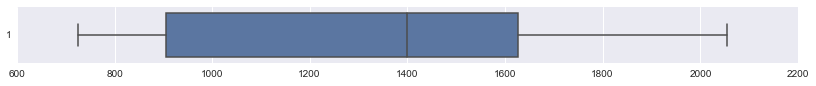

In [42]:
# Library function: sns.boxplot()
plt.figure(figsize=(14,1))
sns.boxplot(X, vert=False)
plt.show()

0-Qunatile 	= [-3.3 <- -3.33 -> -3.3]
0.25-Qunatile 	= [-0.8 <- -0.75 -> -0.7]
0.5-Qunatile 	= [-0.0 <- -0.03 -> -0.0]
0.75-Qunatile 	= [0.6 <- 0.60 -> 0.6]
1-Qunatile 	= [3.5 <- 3.47 -> 3.5]


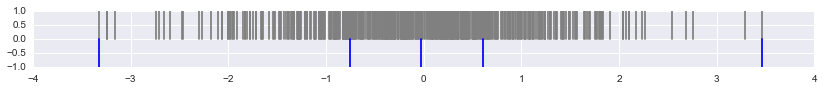

In [43]:
# Box plot for: Normally distributed data

plt.figure(figsize=(14,1))
X = [np.random.normal() for x in xrange(500)]
plot_quantiles(X,[0,0.25,0.5,0.75,1])
plt.show()

# - centered around 0
# - small box compared to whiskers
# - Q(0.25) ~ -0.67 and Q(0.75) ~ 0.67

# "Box plot"-equivalent for a Hisogram Series

* Q(0.25) 
* Q(0.5) - Median
* Q(0.75)

<img src="img/Circonus_Histogram_Box.png"/>

## Outliers

The interquartile range of a sample X is defined as:

`IQR(X) = Q(0.75,X) - Q(0.25,X)`

It is a robust measure for variance of the data.

**Def.** (Tukey, 1969) a k-outlier is a data point X which is either

* larger than `Q(0.75) + k * IQR(X)` or
* smaller than `Q(0.25) - k * IQR(X)`.

An outlier (without k) is an 1.5-outlier.

In [44]:
def IQR(X): return quantile(0.75,X)-quantile(0.25,X)

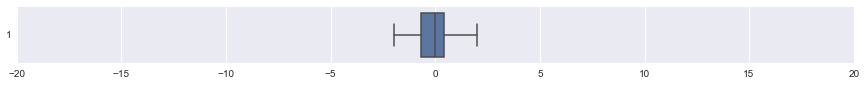

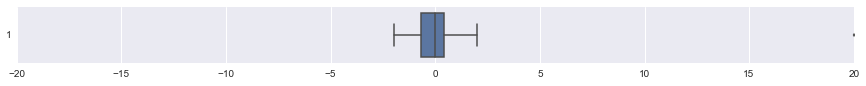

In [45]:
# Tukey Boxplots show outliers as 'points' outside the whiskers

# Normal data
X = [np.random.normal() for x in xrange(100)]

plt.figure(figsize=(15,1))
sns.boxplot(X, vert=False).set_xlim(-20,20)
plt.show()

# Add outlier
XO = X + [20]

plt.figure(figsize=(15,1))
sns.boxplot(XO, vert=False).set_xlim(-20,20)
plt.show()

# Note, that IQR and Median are not affected by the outlier!

# Comparing Distributions

Give two sets of samples $X=[x_1,\dots,x_n]$ and $Y=[y_1,\dots,y_n]$ how similar are the distributions?

* API Latencies before change / after change

Visualizations:

* Rugplots
* Histograms
* Box Plots
* QQ-Plot

Large sample sizes: 73497 84298


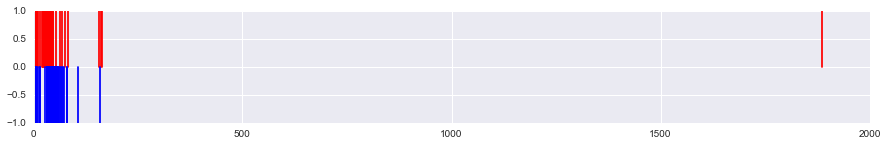

In [46]:
X = np.loadtxt("DataSets/HistogramAPI_samples_1.csv", delimiter=",")
Y = np.loadtxt("DataSets/HistogramAPI_samples_10.csv", delimiter=",")

print "Large sample sizes:", X.size, Y.size

# Too many samples for rug-plot -> select 100 random samples
plt.figure(figsize=(15,2))
sns.rugplot(random.sample(X,100),height=1, color='red')
sns.rugplot(random.sample(Y,100),height=-1, color='blue')

(0, 200)

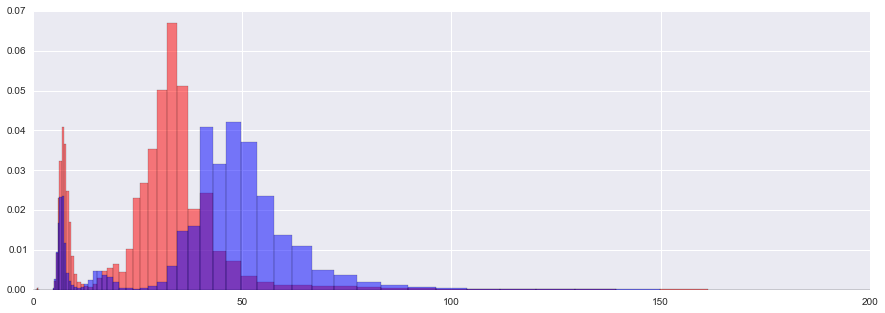

In [47]:
# Use Log-arithmic bins!
# Have to use normed histogram (normed=True)
# Limit axes to focus on relevant parts
plt.figure(figsize=(15,5))
plt.hist(X,bins=np.exp(np.linspace(-10,12,300)),alpha=0.5, color='red',  normed=True)
plt.hist(Y,bins=np.exp(np.linspace(-10,12,300)),alpha=0.5, color='blue', normed=True)
plt.axes().set_xlim(0,200)

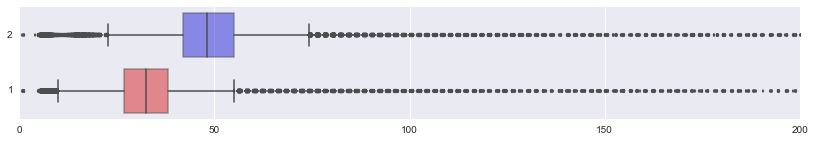

In [48]:
X = np.loadtxt("DataSets/HistogramAPI_samples_1.csv", delimiter=",")
Y = np.loadtxt("DataSets/HistogramAPI_samples_10.csv", delimiter=",")

plt.figure(figsize=(14,2))
sns.boxplot([X,Y], vert=False, color=["red", "blue"], alpha=0.5)
ax = plt.axes().set_xlim(0,200)

# QQ Plots

* Compare two samples
* Can have different sizes
* Are they sampled from the same distribution?
* Where do they differ?

Process:

0. Fix a sequence of numbers $q_1, \dots, q_k$ in [0,1] (quantiles).

1. Calculate the $q_i$-quantiles for $X$ and $Y$.

2. Make a scatter plot between them: $(Q(X,q_i),Q(Y,q_i))$

Clues:

* If graph is concentrated on the diagonal: Same distribution
* Where graph is below the diagonal: $Q(X,q)$ larger than $Q(Y,q)$.
* More on qq-plots: http://www.itl.nist.gov/div898/handbook/eda/section3/qqplot.htm

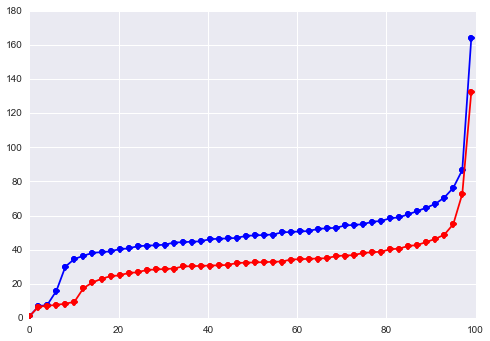

In [49]:
# Warmup: Quantile function

X = np.loadtxt("DataSets/HistogramAPI_samples_1.csv", delimiter=",")
Y = np.loadtxt("DataSets/HistogramAPI_samples_10.csv", delimiter=",")

Q=np.linspace(0,99,50)
QX=np.percentile(X,Q)
QY=np.percentile(Y,Q)

plt.plot(Q,QY, 'bo-')
plt.plot(Q,QX, 'ro-')

In [50]:
# QQ Plot Implementation

def plot_qq(X,Y,n=10):
    QX = []
    QY = []
    for q in np.linspace(0,1,n):
        QX.append(quantile(q,X))
        QY.append(quantile(q,Y))
    
    # mark min, median, max in red.
    color = ['blue'] * n
    color[0] = 'red'
    color[n-1] = 'red'
    color[int(n/2.)] = 'red'
    
    plt.scatter(QX,QY,color=color)
    
    # add digaonal line
    d0 = min(min(QX), min(QY))
    d1 = max(max(QX),max(QY))
    plt.plot([d0,d1],[d0,d1])
    plt.axes().set_aspect(1)

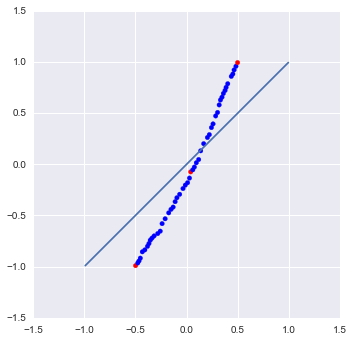

In [51]:
# Uniform [-1,1] vs. Uniform [-2,2]
X = [ np.random.rand()-0.5 for x in xrange(300) ]
Y = [ np.random.rand()*2 - 1 for x in xrange(300) ]
plot_qq(X,Y,50)


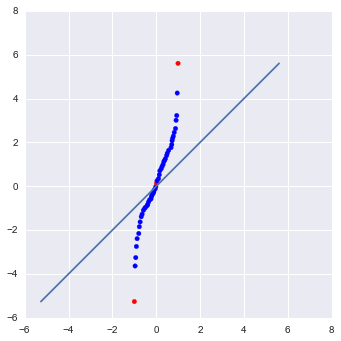

In [52]:
# Uniform distribution compard to normal distribution
X = [ np.random.rand()*2 - 1 for x in xrange(300) ]
Y = [ np.random.normal(0,2) for x in xrange(300) ]
plot_qq(X,Y,50)

(0, 200)

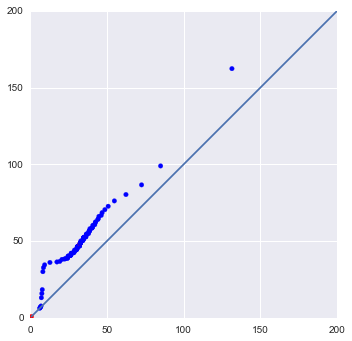

In [53]:
import random

X = np.loadtxt("DataSets/HistogramAPI_samples_1.csv", delimiter=",")
Y = np.loadtxt("DataSets/HistogramAPI_samples_10.csv", delimiter=",")

plot_qq(X,Y, 100)
plt.axes().set_xlim(0,200)
plt.axes().set_ylim(0,200)

# Mutli-Dimensional Data

* Exploring Relationships
  - Scatterplot
  - Correlation
  - Regression
  
  
* Most data is comes dependent on time
  - Trends
  - Periods


* Visualizion
  - Line plot

In [54]:
# Request rates to nodes in a cluster
X = np.loadtxt("DataSets/ReqMultiNode.csv", delimiter=',', usecols=(0,1,2,3,4,5))[:2000]
T, A, B, C, D, E = X.T

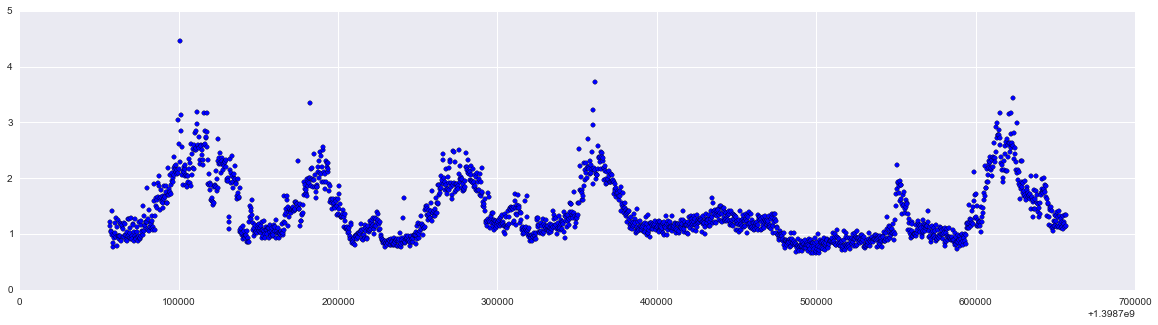

In [55]:
# Discover relationships with Scatterplots
plt.figure(figsize=(20,5))
plt.scatter(T,A) #-> Functionla dependency

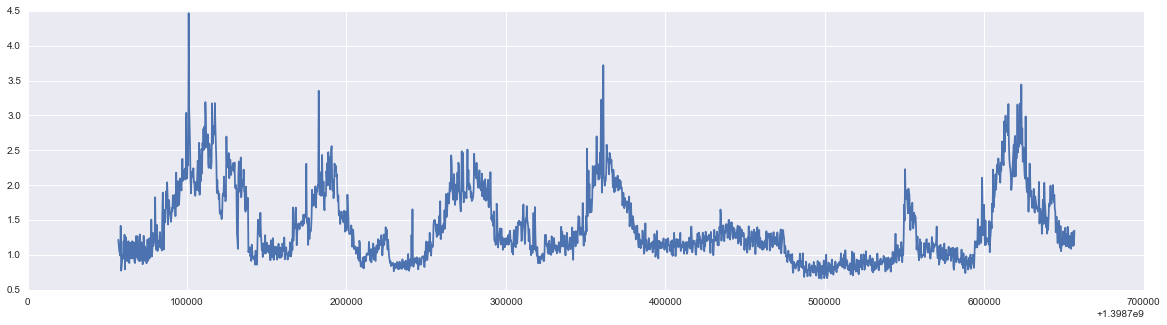

In [56]:
# Join with lines to get the impression of continuity (use with care)
plt.figure(figsize=(20,5))
plt.plot(T,A)

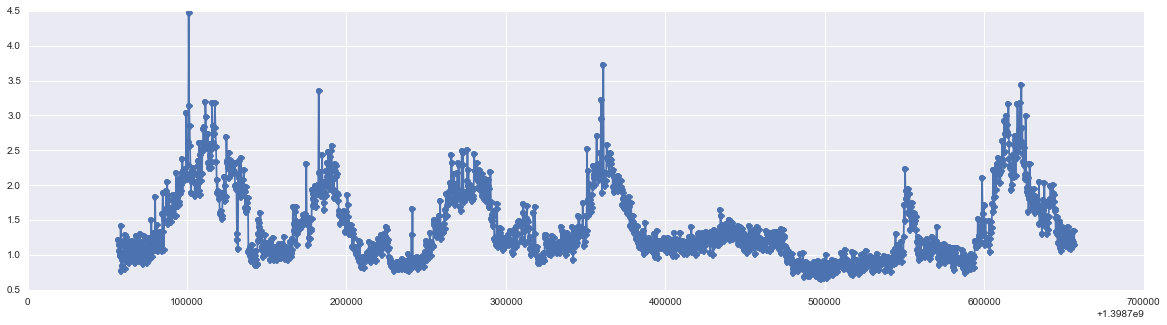

In [57]:
# Better: Show datapoints
plt.figure(figsize=(20,5))
plt.plot(T,A,'o-')

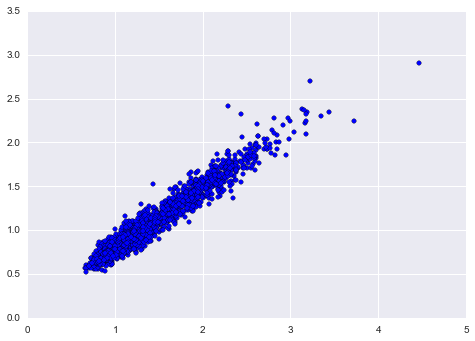

In [58]:
# Scatter plot shows relation between A and B
plt.scatter(A,B)
plt.axes().set_aspect(1)

# 2D vs 1D Visualizations

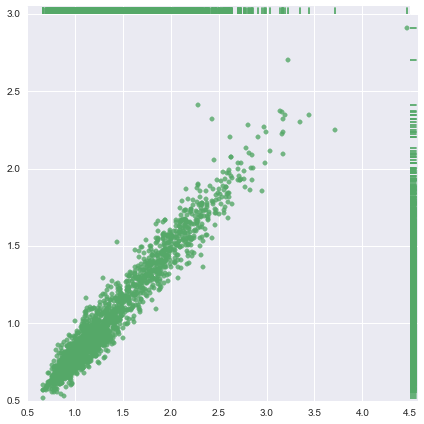

In [59]:
# Scatter plot with marginal rugplots
# - project to X and Y axis

color = sns.color_palette()[1]
grid = sns.JointGrid(A, B, space=0, size=6, ratio=50)
grid.plot_joint(plt.scatter, color=color, alpha=.8)
grid.plot_marginals(sns.rugplot, color=color)

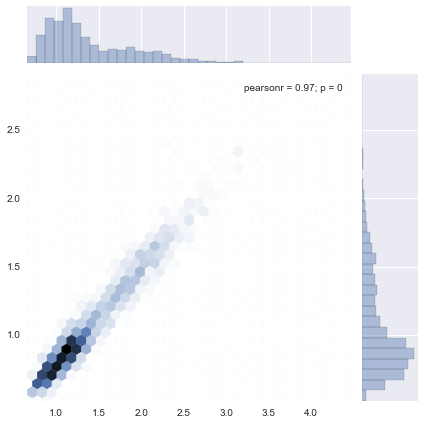

In [60]:
# Hex-Plot with marginal histograms
# - Two dimensional histogram
# - Count as color coding

sns.jointplot(A,B,kind="hex")

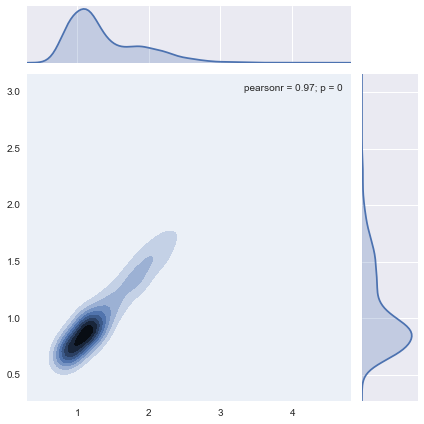

In [61]:
# 2-D kernel density plot

sns.jointplot(A,B,kind="kde")

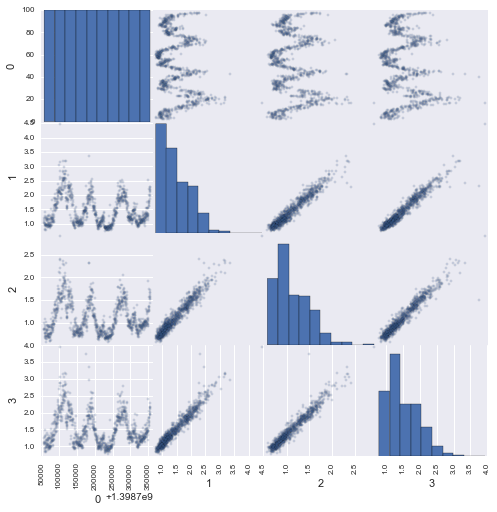

In [62]:
# Exploring Multi-dimensional relationshipts with a Scatter Plot Matrix

import pandas as pd
from pandas.tools.plotting import scatter_matrix
data = np.array([T,A,B,C])
df = pd.DataFrame(data.T[:1000])
scatter_matrix(df, alpha=0.2, figsize=(8, 8))
pass

# Qunatifying Relations

## Pearson Correlation

* Detects only linear dependence
* Independent of slope of dependence
* Independent of constant offsets

<center>
<img src="http://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/400px-Correlation_examples2.svg.png">

Distributions and Pearson Correlation <br/>
Source: Wikipedia, DenisBoigelot under CC0-license  
</center>

## Definition and Computation

Let $(X,Y)=(x_i,y_i), i=1,\dots,n$ be two-dimensional sample set.

The _covariance_ of $X$ and $Y$ is defined as:

$$Cov(X,Y) = \frac{1}{n} \sum_i (x_i - \mu_X) \cdot (y_i - \mu_Y)$$

The _variance_ of $X$ is defined as:

$$Var(X) = Cov(X,X)$$

* $Var(X)$ is related to the standard deviation by

$$\sigma_X = \sqrt{Var(X)}$$

* $Cov(X,Y)$ is bi-linear, i.e. scaling $X$ or $Y$ linearly, scales $Cov(X,Y)$ linearly.

* The following inequality holds (Cauchy-Schwary)
  $$ Cov(X,Y)^2 \leq Var(X) \cdot Var(Y).$$

The (Pearson) _correlation_ $\rho$ is defined as

$$ \rho(X,Y)^2 = \frac{Cov(X,Y)^2}{Var(X) \cdot Var(Y)} = \frac{Cov(X,Y)}{\sigma_X \cdot \sigma_Y}$$

By Cauchy-Schwary inequality we have $0\leq \rho^2 \leq 1$.

* More insight into $\rho$ comes from linear regression.

In [63]:
# Libarary Function
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.cov.html#numpy.cov


print 'r(T,A) = ', np.corrcoef(T,A)[0,1], '(functional, non-linear  dependency)'
print 'r(A,B) = ', np.corrcoef(A,B)[0,1], '(non-function, near-linear dependency)'

print np.corrcoef.__doc__

r(T,A) =  -0.162938257457 (functional, non-linear  dependency)
r(A,B) =  0.970715492556 (non-function, near-linear dependency)

    Return correlation coefficients.

    Please refer to the documentation for `cov` for more detail.  The
    relationship between the correlation coefficient matrix, `P`, and the
    covariance matrix, `C`, is

    .. math:: P_{ij} = \frac{ C_{ij} } { \sqrt{ C_{ii} * C_{jj} } }

    The values of `P` are between -1 and 1, inclusive.

    Parameters
    ----------
    x : array_like
        A 1-D or 2-D array containing multiple variables and observations.
        Each row of `m` represents a variable, and each column a single
        observation of all those variables. Also see `rowvar` below.
    y : array_like, optional
        An additional set of variables and observations. `y` has the same
        shape as `m`.
    rowvar : int, optional
        If `rowvar` is non-zero (default), then each row represents a
        variable, with observations in the col

# Functional Dependence


Give two samples $X,Y$ where we suspect a functional relationship of the form:

$$y_i = f(x_i)$$

* How can we determine the best candidate for $f$?
* How can we asses the quality of the fit?

## Regression Method:

* Parametric Ansatz for $f(x) = f(\theta; x)$

* Define residuals $e_i$ by:

$$y_i = f(\theta; x_i) + e_i$$

* Loss function:

$$ Loss(\theta) = \sum_i e_i^2 = \sum_i (y_i - f(\theta;x_i))^2 $$ 

* Chosse $\theta$ by minimizing $Loss(\theta)$.

## Warmup: Constant Model

* Parametric Ansatz for f: $f(x) = a$, constant.
* Quadratic loss function:

$$ Loss(a) = \sum_i (y_i - a)^2 $$

* Minimize loss function (_using calculus!_) gives mean value:

$$ \hat{a} = \frac{1}{n} \sum_i y_i = \mu_Y $$

* Minimal Loss:

$$ MinLoss(X,Y) = \sum_i (y_i - \mu_Y)^2 = n \cdot Var(Y) $$

* $Var(Y)$ measures goodness of constant fit!

* No dependence on $X$ (as expected).


## Simple Linear Regression 

* Parametric Ansatz for f:
  $$f(a,b; x) = bx + a, \quad \theta=(a,b)$$

* Quadratic loss function:

$$ Loss(a,b) = \sum_i e_i^2 = \sum_i (y_i - f(x_i))^2 =  \sum_i (y_i - b x_i - a)^2 $$ 

$$ = a^2 A + ab \cdot B + b^2 \cdot C + D$$

for some variables $A,B,C,D$ depending on $X,Y$.

* Regression: Minimize $Loss(a,b)$ with respect to parameters $(a,b)$.

* Since $Loss(a,b)$ is quadratic, it has a unique minimum which is easy to compute:

$$\hat{b} =  \frac{\sum_i (x_i - \mu_x)(y_i - \mu_y)}{\sum_i(x_i - \mu_x)^2} = Cov(X,Y) / Var(X) = \rho_{X,Y} \frac{\sigma_Y}{\sigma_X}$$

$$\hat{a} = \mu_Y - \hat{b} \mu_X $$


* See (http://en.wikipedia.org/wiki/Simple_linear_regression) for a derivation.

* Works also for more complex functions (e.g. polynomials)

* Name "linear" regression comes from "quadratic" (!) loss function.

* Note that Pearson Correlation appears in formula for $\hat{b}$.

model = 0.100420188 + 0.689291938183 * x


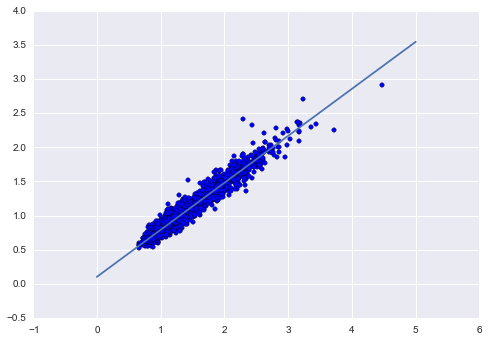

In [64]:
# Library Function for linear regression:
#
# stats.linregress?
#

from scipy import stats
b, a, r_value, p_value, std_err = stats.linregress(A,B)

print "model = {} + {} * x".format(a,b)

grid = [0,1,2,3,4,5]
f    = lambda x: a + b*x

plt.scatter(A,B)
plt.plot(grid, map(f, grid))

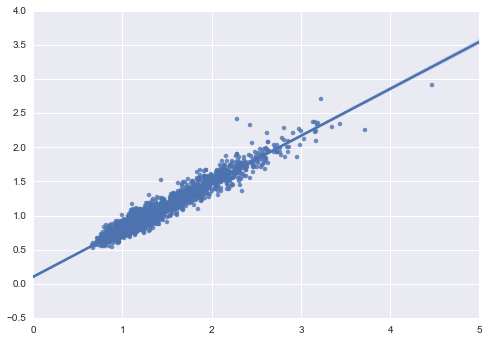

In [65]:
# Regression Plot
#
# sns.regplot?

sns.regplot(A,B)

# Capacity Planning with Regressions

* Forecasting of disc space usage

- share: https://share.circonus.com/embedded/graphs/48970eef-364b-4094-83a2-794232cb1abc/Vcj2R0#no-set
- graph: https://circonus-ops.circonus.com/trending/graphs/view/48970eef-364b-4094-83a2-794232cb1abc#set-XymqcLn9

<img src="img/Circonus_Regression.png">

## Goodness of fit

* Natural measure for goodness of fit is the Loss of the ideal fit viewed as a function of $X$ and $Y$:

$$ MinLoss(X,Y) = \sum_i (y_i - \hat{b} x_i - \hat{a})^2 $$

* Problem: Scales (quadratic) with $Y$: $MinLoss(X,3 Y)=9 MinLoss(Y)$ without the regression getting better or worse. 

* Use loss of constant regression (ie. mean value):

  $$ ConstLoss(Y) = \sum_i (y_i - \mu_y)^2  = n \cdot Var(Y) $$
  
**Def:** The $R^2-Value$ value is

$$ R^2 = 1 - \frac{MinLoss(X,Y)}{ConstLoss(Y)}$$

* Lies in [0,1].
* Perfect fit if $R^2=1$

* Scaling invariance: Does not change when $X,Y$ is replaced by $a X, b Y$.

* Can be viewed as variance ratio $SS_{reg} / SS_{tot}$.
  http://en.wikipedia.org/wiki/Coefficient_of_determination

**Proposition:** $R^2= \rho^2$ Pearson correlation!

Hence: Pearson Correlation measures how well a linear model fits the plot.

In [66]:
# Check R2 = Pearson Correlation

def loss(a,b,X,Y): return sum( (y - a - b*x)**2 for x,y in zip(X,Y))

print "R-2 computed = ", 1 - loss(a,b,A,B) / loss(np.mean(B),0,A,B)
print "R-2 provided = ", r_value**2

print "r-2 Pearson  = ", np.corrcoef(A,B)[0,1]**2

R-2 computed =  0.942288567489
R-2 provided =  0.942288567489
r-2 Pearson  =  0.942288567489


# Time Series Forecasting with Holt Winters

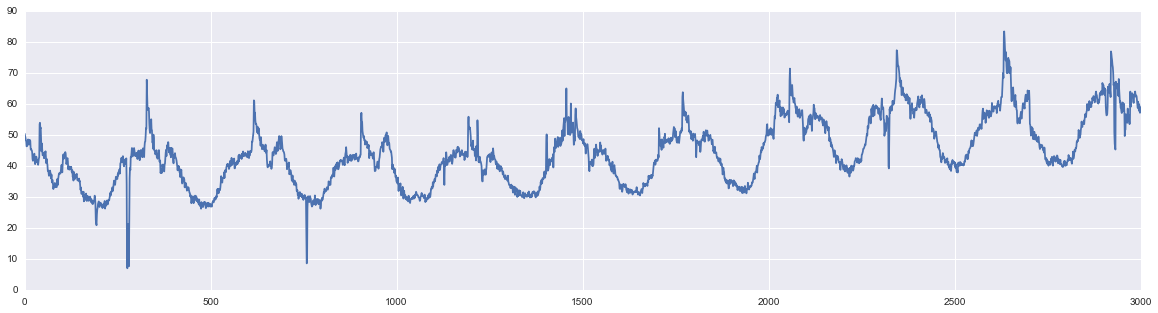

In [67]:
# Request data with period and trend
Y = np.loadtxt("DataSets/ReqRateTrend.csv", delimiter=',')[:3000,1]
plt.figure(figsize=(20,5))
plt.plot(Y)

In [68]:
# Constant Model

class ExponentialSmoothModel(object):
    def __init__(self, alpha, s0=0):
        self.alpha = alpha
        self.s     = s0
        
    def update(self, y):
        self.s = self.s * self.alpha + (1 - self.alpha) * y
        
    def get(self, t): # returns y{+t}
        return self.s

def run(Y, model, tau=0):
    for y in Y:
        model.update(y)
        yield model.get(0)
        
    for t in xrange(1,tau+1):
        yield model.get(t)

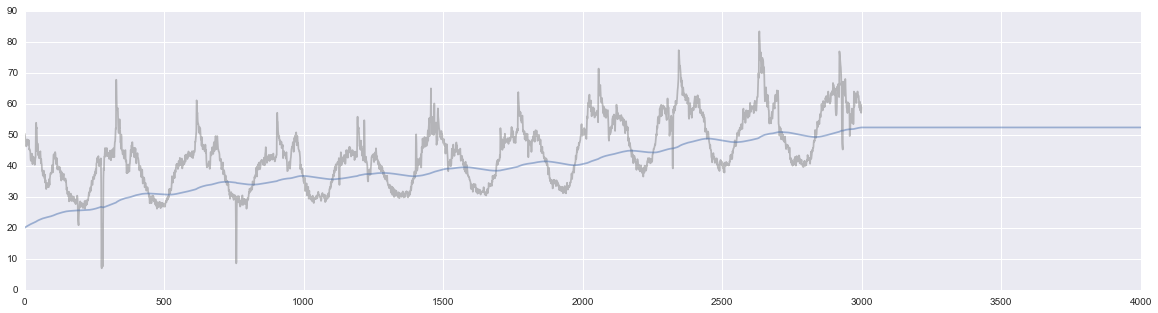

In [69]:
plt.figure(figsize=(20,5))
plt.plot(Y, color='grey', alpha=0.5)
plt.plot(list(run(Y, ExponentialSmoothModel(0.998, s0=20),tau=1000)), alpha=0.5)

In [70]:
# Linear Data Model:

class DoubleExponentialSmoothModel(object):
    def __init__(self, alpha, beta, s0=0, b0=0):
        self.alpha = alpha
        self.beta  = beta
        self.s     = s0
        self.b     = b0
        
    def update(self, y):
        s1 = self.s
        self.s  = self.alpha * (self.s + self.b)  + (1 - self.alpha) * y 
        self.b  = self.beta  *  self.b            + (1 - self.beta)  * (self.s - s1)
        
    def get(self, t): # returns y{t0 + t}
        return self.s + t * self.b
    

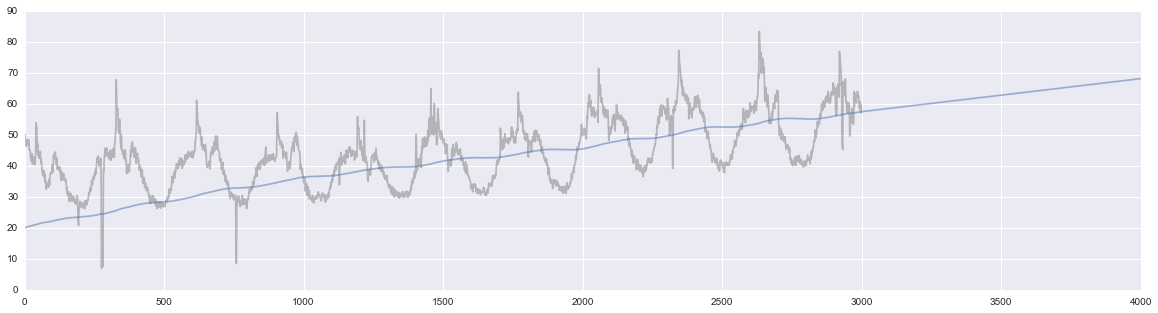

In [71]:
plt.figure(figsize=(20,5))
plt.plot(Y, color='grey', alpha=0.5)
plt.plot(list(run(Y, DoubleExponentialSmoothModel(0.999, 0.999, s0=20),tau=1000)), alpha=0.5)

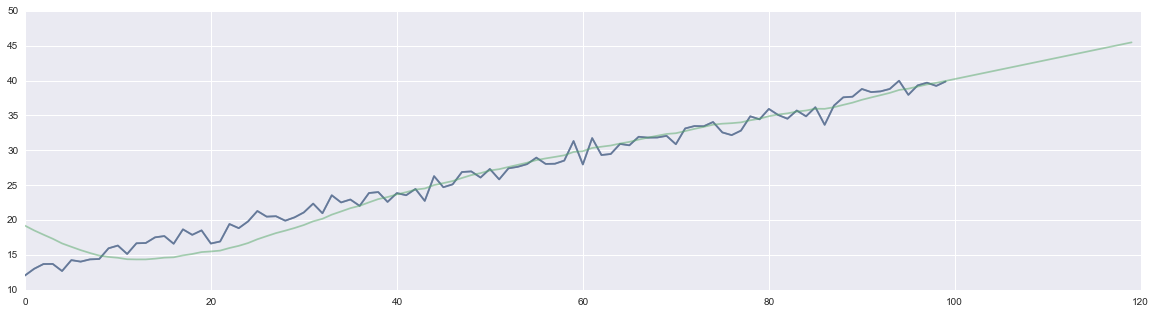

In [72]:
# Trend Model on Generated Data

Z = [ 10 + 3*x + np.random.normal() for x in np.linspace(1,10,100)]

plt.figure(figsize=(20,5))
plt.plot(Z)
plt.plot(Z, color='grey', alpha=0.5)
plt.plot(list(run(Z, DoubleExponentialSmoothModel(0.9, 0.9, s0=20),tau=20)), alpha=0.5)

In [73]:
# Periodic Model

day = (60 * 24) / 5 # 5m sampling

class PeriodicExponentialSmoothModel(object):
    def __init__(self, alpha, gamma, s0=0, period=day):
        self.alpha = alpha
        self.gamma = gamma
        self.period = period
        
        self.s     = s0
        self.c     = [0] * period
        self.i     = -1
        
    def update(self, y):
        self.i = (self.i + 1) % self.period
        i      = self.i
        self.s  =    self.alpha  * self.s    + (1 - self.alpha) * (y - self.c[i])
        self.c[i] =  self.gamma  * self.c[i] + (1 - self.gamma) * (y - self.s)
        
    def get(self, t): # returns y{+t}
        return self.s + self.c[(self.i + t) % self.period]

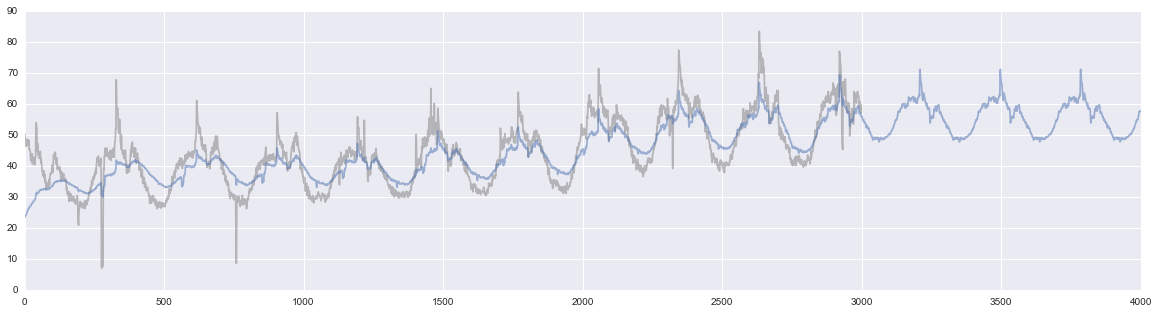

In [74]:
plt.figure(figsize=(20,5))
plt.plot(Y, color='grey', alpha=0.5)
plt.plot(list(run(Y, PeriodicExponentialSmoothModel(0.99, 0.9, s0=20),tau=1000)), alpha=0.5)

In [75]:
class TripleExponentialSmoothModel(object):
    def __init__(self, alpha, beta, gamma, s0=0,  b0=0, period=day):
        self.alpha = alpha
        self.beta  = beta
        self.gamma = gamma
        self.period = period
        
        self.s     = s0
        self.b     = b0
        self.c     = [0] * period
        self.i     = -1
        
    def update(self, y):
        self.i = (self.i + 1) % self.period
        i      = self.i
        s1 = self.s
        self.s  =    self.alpha  * (self.s + self.b)  + (1 - self.alpha) * (y - self.c[i])
        self.b  =    self.beta   * self.b             + (1 - self.beta)  * (self.s - s1)
        self.c[i] =  self.gamma  * self.c[i]          + (1 - self.gamma) * (y - self.s)
        
    def get(self, t): # returns y{+t}
        return self.s + self.b * t + self.c[(self.i + t) % self.period]
    

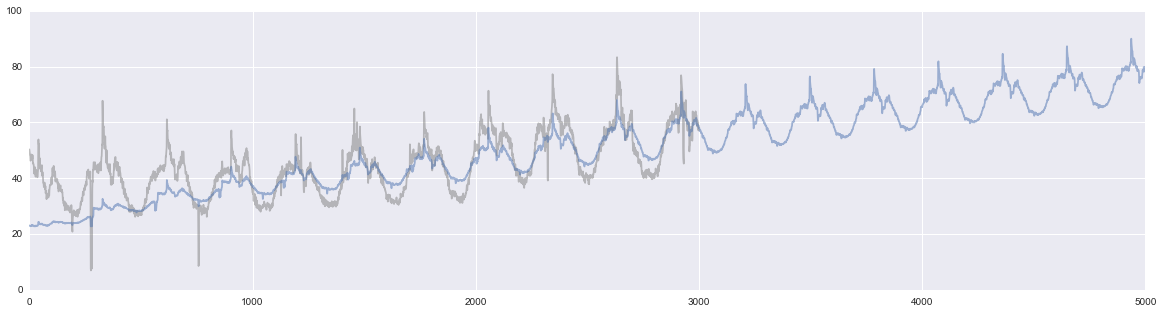

In [76]:
plt.figure(figsize=(20,5))
plt.plot(Y, color='grey', alpha=0.5)
plt.plot(list(run(Y, TripleExponentialSmoothModel(0.999, 0.999, 0.9, s0=20),tau=2000)), alpha=0.5)